In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Dependencies

In [ ]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
from tensorflow import keras

Loading Cora Dataset

In [ ]:

os.getcwd()
os.chdir(r"drive/My Drive/cora dataset")

In [ ]:
cites = pd.read_csv('cora.cites.txt',delimiter="\t",header=None,names=["ID of cited paper","ID of citing paper"] )
cites=np.array(cites.values.tolist())

Creating paper ID dictionary

In [ ]:
idx = list(set(cites.flatten()))
idx_map = {j: i for i, j in enumerate(idx)}

In [ ]:
edges = np.array(list(map(idx_map.get, cites.flatten()))).reshape(cites.shape)

Creating Graph adjacency matrix from adjency list

In [ ]:



n = len(edges)
m=len(idx)
adj_matrix =np.zeros((m,m),dtype = int)
    

for i in range(n):
    adj_matrix[edges[i][0],edges[i][1]] = 1


In [ ]:
adj_matrix.shape

In [ ]:
content = pd.read_csv('cora.content.txt',delimiter="\t",header=None)
content.set_index(content.columns[0],inplace=True)
content.index=np.array(list(map(idx_map.get, content.index)))


One hot encoding Features

In [ ]:
one_hot = pd.get_dummies(content[1434])

content = content.drop(1434,axis = 1)

custom Graph convolutional layer with spectral propogation rule

In [ ]:


class SpectralRule(keras.Model):

    def __init__(self,A, in_units, out_units,activation):
        super(SpectralRule,self).__init__()

        I = np.eye(*A.shape)
        A_hat = A.copy() + I
        D = np.sum(A_hat, axis=0)
        D_inv = D**-0.5
        D_inv = np.diag(D_inv)
        A_hat = D_inv * A_hat * D_inv

        self.in_units, self.out_units = in_units, out_units
        self.activation = keras.layers.Activation(activation)
        w_init = tf.random_normal_initializer()

        self.A_hat = tf.cast(A_hat, tf.float32)
        self.w = tf.Variable(initial_value=w_init(shape=(in_units, out_units), dtype="float32"),trainable=True)

    def call(self, X):
        aggregate = tf.matmul(self.A_hat, tf.cast(X, tf.float32))
        propagate = self.activation(tf.matmul(aggregate, self.w))
        return propagate


Costom model with 2 Garph convolution layer and a softmax layer for classification

In [ ]:

class MyModel(tf.keras.Model):

  def __init__(self,nfeat,nhid,nclass):
    super(MyModel, self).__init__()
    self.gc1 = SpectralRule(adj_matrix,nfeat,nhid, activation=tf.nn.tanh)
    self.gc2 = SpectralRule(adj_matrix,nhid,nclass, activation=tf.nn.relu)
    self.dropout=tf.keras.layers.Dropout(0.2)
  def call(self, inputs,training=False):
    x = self.gc1(inputs)
    x = self.dropout(x, training=training)
    x = self.gc2(x)
    return tf.nn.softmax(x)





calling model class

In [ ]:
model=MyModel(1433,256,7)

Tinkered with optimizers
best :-Adam

In [ ]:

opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=opt)

In [ ]:
history=model.fit(content, one_hot,batch_size=content.shape[0], epochs=50, shuffle=False, verbose=1)

Epoch 1/50
1/1 [==============================] - 0s 6ms/step - loss: 1.9463
Epoch 2/50
1/1 [==============================] - 0s 3ms/step - loss: 1.8482
Epoch 3/50
1/1 [==============================] - 0s 1ms/step - loss: 1.7271
Epoch 4/50
1/1 [==============================] - 0s 1ms/step - loss: 1.6131
Epoch 5/50
1/1 [==============================] - 0s 1ms/step - loss: 1.5087
Epoch 6/50
1/1 [==============================] - 0s 1ms/step - loss: 1.4099
Epoch 7/50
1/1 [==============================] - 0s 1ms/step - loss: 1.3170
Epoch 8/50
1/1 [==============================] - 0s 1ms/step - loss: 1.2282
Epoch 9/50
1/1 [==============================] - 0s 1ms/step - loss: 1.1429
Epoch 10/50
1/1 [==============================] - 0s 1ms/step - loss: 1.0644
Epoch 11/50
1/1 [==============================] - 0s 1ms/step - loss: 0.9904
Epoch 12/50
1/1 [==============================] - 0s 1ms/step - loss: 0.9211
Epoch 13/50
1/1 [==============================] - 0s 2ms/step - loss: 0.

In [ ]:
print(history.history.keys())

dict_keys(['loss'])


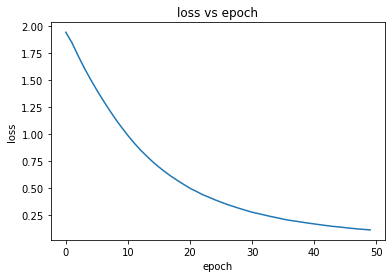

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.title('loss vs epoch')
plt.show()

In [ ]:
pred_y=model(content,training=False)
pred_y

<tf.Tensor: shape=(2708, 7), dtype=float32, numpy=
array([[5.21955978e-10, 2.78741097e-09, 9.99978900e-01, ...,
        5.21955978e-10, 5.44359624e-09, 1.14777645e-08],
       [3.42759900e-02, 4.78133112e-02, 9.76497959e-03, ...,
        9.76497959e-03, 8.63254726e-01, 2.19010543e-02],
       [3.24802477e-06, 8.63279638e-05, 1.57162809e-04, ...,
        9.99743521e-01, 3.24802477e-06, 3.24802477e-06],
       ...,
       [2.85144401e-29, 1.00000000e+00, 1.57289194e-29, ...,
        1.57289194e-29, 1.57289194e-29, 1.19524840e-27],
       [1.00000000e+00, 4.07557601e-19, 5.77431036e-21, ...,
        6.57520336e-21, 5.77431036e-21, 4.95059486e-20],
       [7.23269751e-13, 7.23269751e-13, 1.00000000e+00, ...,
        7.94205240e-12, 2.68186862e-10, 7.23269697e-13]], dtype=float32)>

In [ ]:

idx = np.argmax(pred_y, axis=-1)
a = np.zeros( pred_y.shape )
a[ np.arange(a.shape[0]), idx] = 1

print(a)

[[0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]]


In [ ]:
count=0
for i in range(a.shape[0]):
  if list(a[i])==list(one_hot.iloc[i]):
    count+=1

print("training accuracy is " + str(count/a.shape[0]) )


training accuracy is 0.9855982274741507
